In [6]:
%cd ..

/Users/queen/Documents/KNG/keras_classification


In [20]:
import tensorflow as tf
import cv2
import argparse
import os
from typing import Tuple, Any
from glob import glob
from tqdm import tqdm
import re
import pandas as pd
from rembg import remove

In [21]:
def predict(image, model, list_classes: list, size, threshold: float) -> Tuple[str, float]:
    """
    Predict class of image
    :param threshold: the threshold to check confidence, if output is lower than threshold, the class is 'other'
    :param list_classes: the list of all name classes
    :param size: size to resize image
    :param image: image to predict
    :param model: model to predict
    :return: A tuple with two items: class name and the confidence of output
    """
    # Convert from BGR to RGB
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    # Resize image
    image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    # Normalize image
    image = (image / 127.5) - 1.0
    # Convert data to float32
    image = tf.cast(image, tf.float32)
    # Predict
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    model.set_tensor(input_details[0]['index'], image[tf.newaxis, ...])
    model.invoke()
    output_data = model.get_tensor(output_details[0]['index'])[0]
    # Get class index
    cls_idx = tf.argmax(output_data, axis=0)
    # Get class name
    cls_name = list_classes[cls_idx]
    # Check confidence
    if output_data[cls_idx] < threshold:
        return 'other', output_data[cls_idx]
    return cls_name, output_data[cls_idx]


def draw_result(image, cls_name: str, color) -> Any:
    """
    Draw the class name (result) to the image
    :param image: the input image
    :param cls_name: the class is predicted
    :return: the image after drawed cls_name
    """
    height, width = image.shape[:2]
    x, y = 10, height // 8
    fs = min(height, width) // 200
    # Put text to image
    image = cv2.putText(image, cls_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, fs, color=color, thickness=fs)
    return image


def load_model(model_path: str) -> Any:
    """
    Load model to predict
    :param model_path: the path of predict model
    :return: the model after load
    """
    # Load model .tflite from file
    model = tf.lite.Interpreter(model_path)
    # Allocate tensor
    model.allocate_tensors()
    return model


def main(model, input, output, size=(256, 256), threshold=0.2):
    # The list of all classes
    list_classes = ['001', '002', '003', '004', '005', '006', '007', '008',
                    '009', '010', '011', '012', '013', '014', '015', '016',
                    '017', '018', '019', '020', '021', '022', '023', '024']
    # Load model
    # print("\n Load model" + "." * 10)
    model = load_model(model)
    # Read image
    # print("\n Read image" + "." * 10)
    image = cv2.imread(input)
    # Predict
    # print("\n Classify" + "." * 10)
    cls_name, score = predict(image, model, list_classes, size, threshold)
    # Draw image
    # print("\n Draw result" + "." * 10)
    # image = draw_result(image, cls_name)
    # Write image
    # print("\n Write result" + "." * 10)
    # cv2.imwrite(f"{output}/{os.path.basename(input)}", image)
    # print("\n The classify process for Cat Noodles is done!")
    
    return cls_name, score

In [29]:
list_classes = ['001', '002', '003', '004', '005', '006', '007', '008',
                '009', '010', '011', '012', '013', '014', '015', '016',
                '017', '018', '019', '020', '021', '022', '023', '024']

size=(256, 256)
threshold=0.5

In [30]:
true = 'OK'
false = 'NG'

In [24]:
model_path = './model/EFNB3_29032023_034649.tflite'
model = load_model(model_path)

In [31]:
result_path = './result_v3.0/'
if not os.path.exists(result_path):
    os.mkdir(result_path)

In [32]:
with pd.ExcelWriter(f"./{result_path}/out_v3.0.xlsx") as writer:
    for test_folder in glob('./data/*'):
        if os.path.isdir(test_folder):
            df = pd.DataFrame(columns=['image', 'true_class', 'predict_class', 'score', 'result'])
            output = f'{result_path}/{os.path.basename(test_folder)}'
            if not os.path.exists(output):
                os.mkdir(output)
            if not os.path.exists(f'{output}/{true}'):
                os.mkdir(f'{output}/{true}')
            if not os.path.exists(f'{output}/{false}'):
                os.mkdir(f'{output}/{false}')
                
            for input in tqdm(glob(f'{test_folder}/*')):                                
                original = cv2.imread(input)
                image = remove(original)
                cls_name, score = predict(image, model, list_classes, size, threshold)
                
                true_cls = re.search(r'\d+', input).group(0).zfill(3)      
                result = true if true_cls == cls_name else false
                df.loc[len(df)] = [os.path.basename(input), str(true_cls), str(cls_name), f"{score:.3f}", result]
                
                if result == true:
                    color = (0, 255, 0)
                else:
                    color = (255, 0, 0)
                result_image = draw_result(original, cls_name, color)
                cv2.imwrite(f"{output}/{result}/{os.path.basename(input)}", result_image)
                
            df.to_excel(writer, sheet_name=os.path.basename(test_folder), index=False)

100%|███████████████████████████████████████████| 24/24 [00:52<00:00,  2.17s/it]


In [33]:
!cp model/EFNB3_29032023_034649.tflite /Users/queen/Documents/KNG/cat_noodles/CAT_NOODLES/model

In [51]:
from rembg import remove
import cv2
from PIL import Image

In [56]:
image = cv2.imread('./data/front_trimming/trim_trim_No.1_front.jpg')


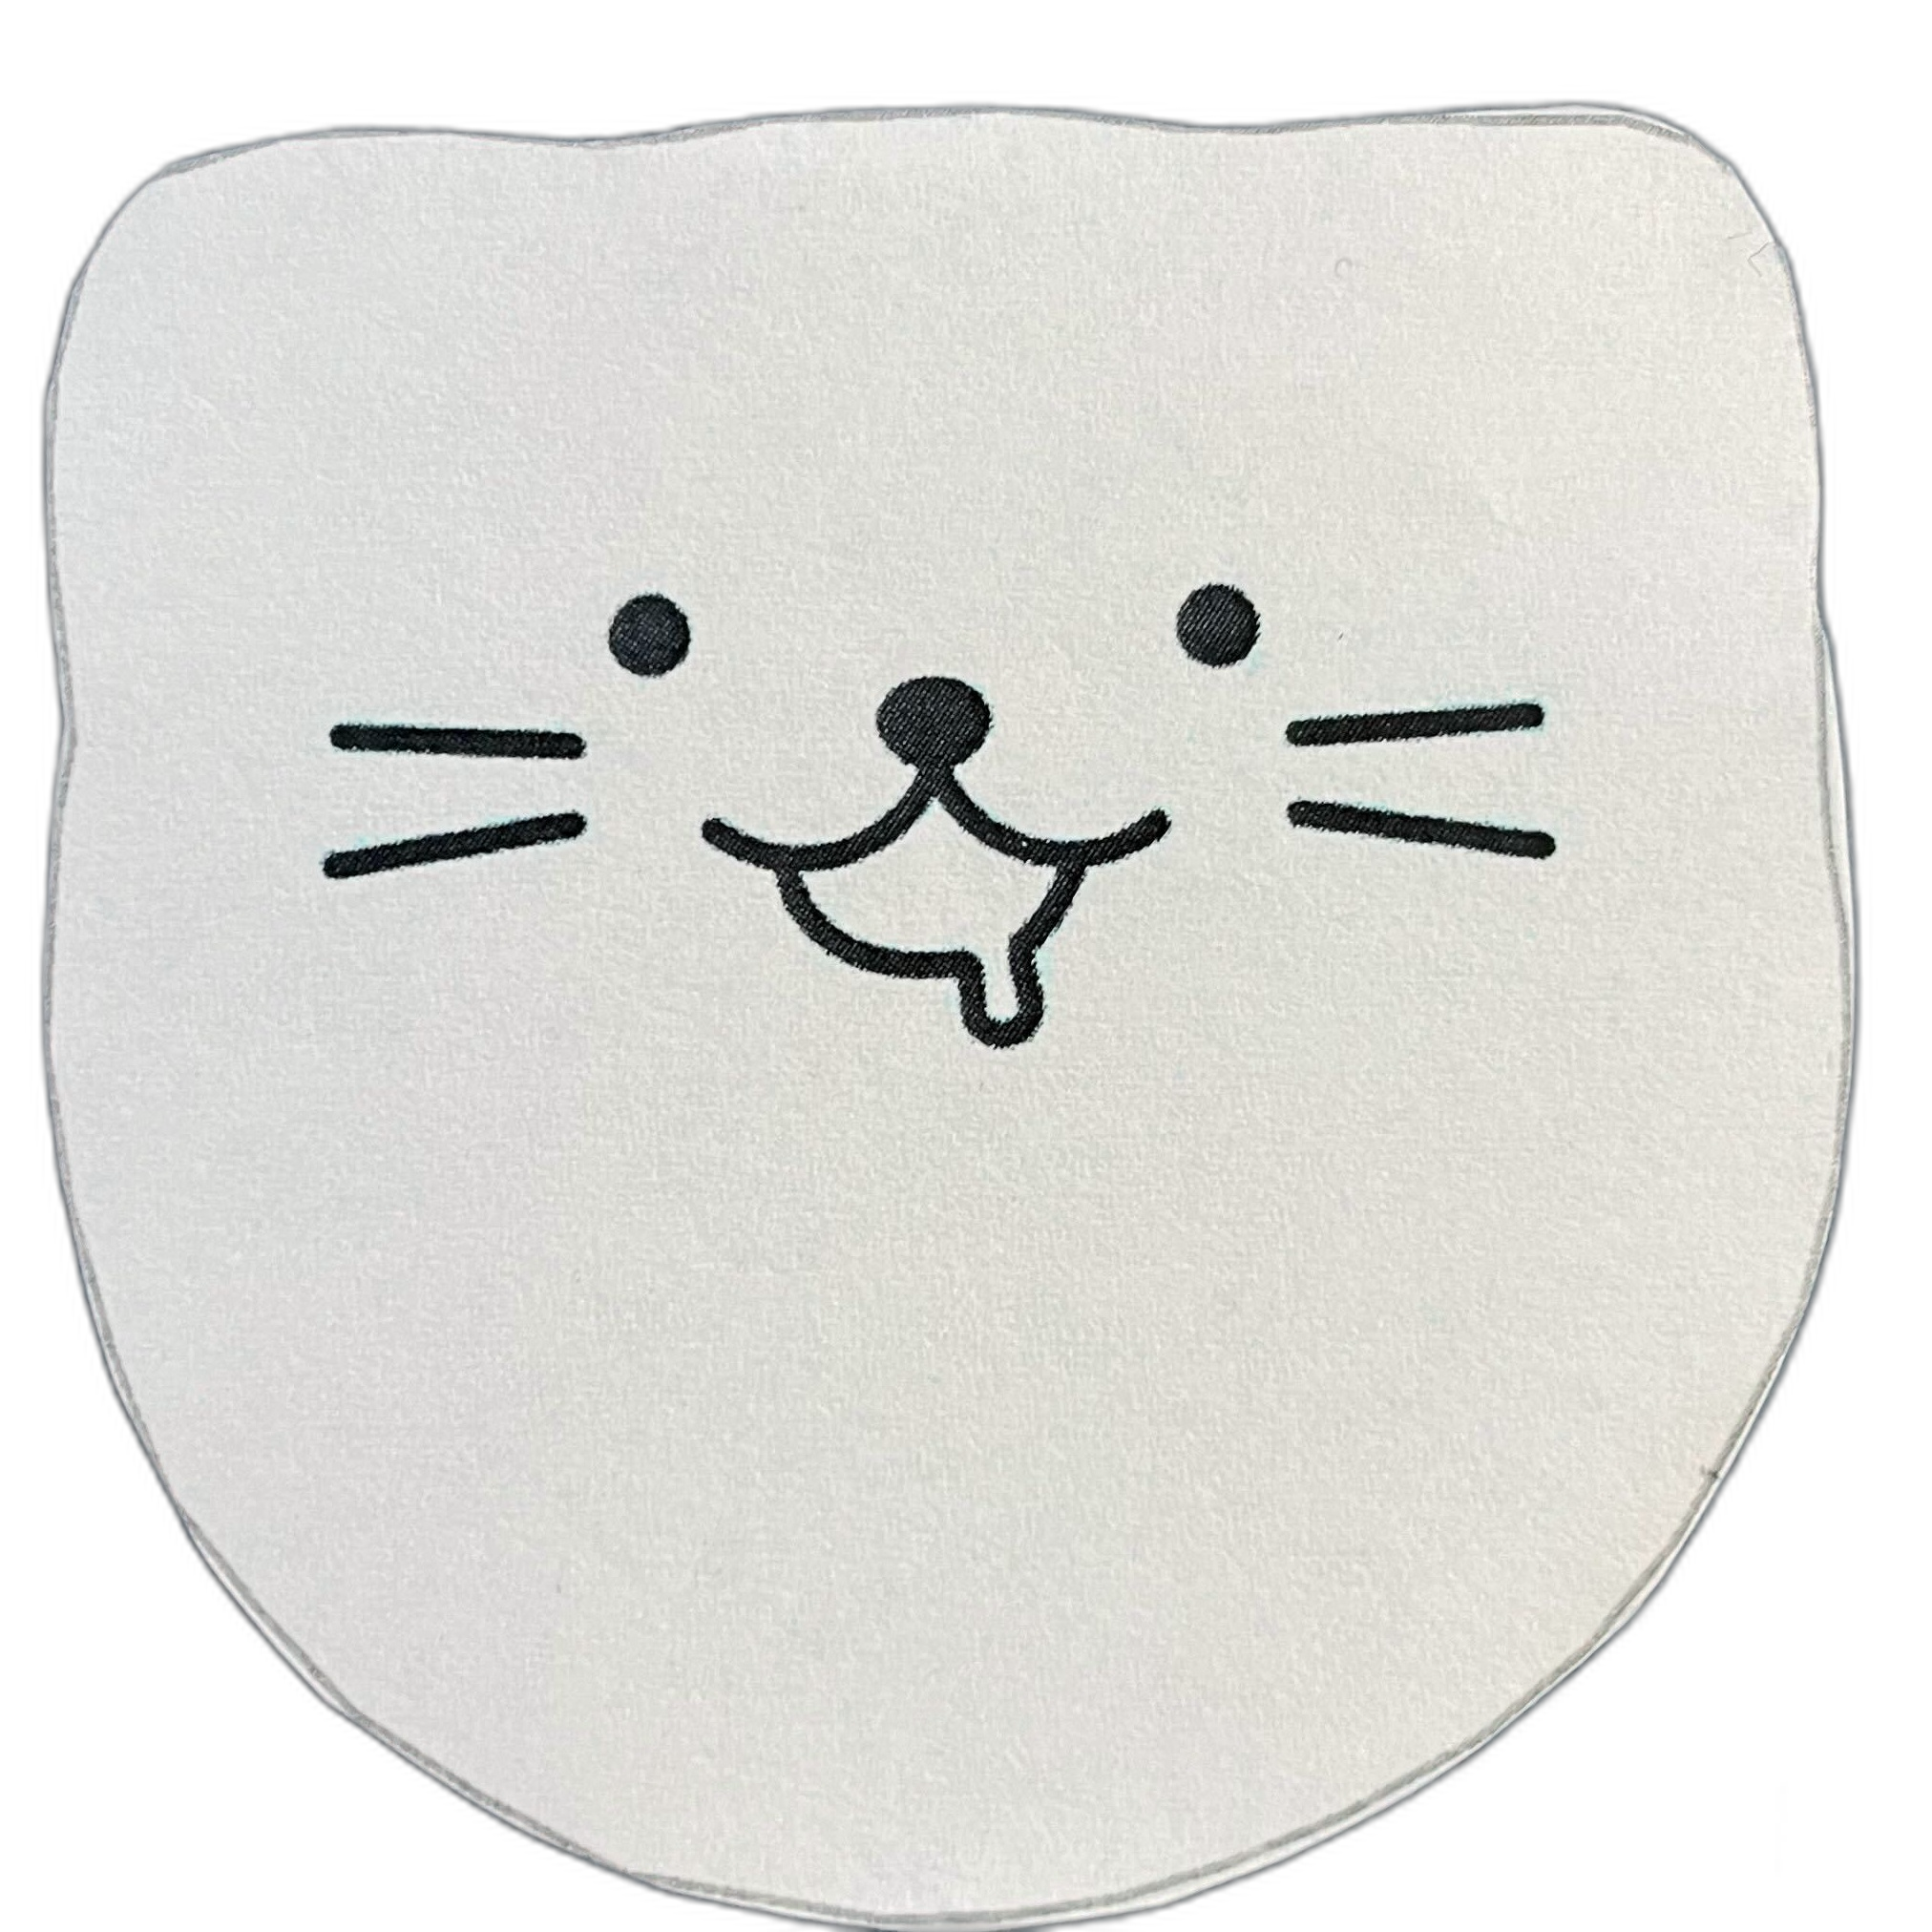

In [57]:
Image.fromarray(img)